In [245]:
def get_dataLoader():

    current_path = os.getcwd()
    train_path = os.path.join(current_path, '..', '..', '02514', 'hotdog_nothotdog', 'train')
    test_path = os.path.join(current_path, '..', '..', '02514', 'hotdog_nothotdog', 'test')
    

    transform = transforms.Compose([
    transforms.Resize((224,224)), # resizing to same size, for example 224x224
    transforms.ToTensor(),])


    trainset = datasets.ImageFolder(train_path, transform=transform)
    testset = datasets.ImageFolder(test_path, transform=transform)

    #Get a random image from the test set and its path
    random_image_index = np.random.randint(0, len(testset))
    random_image = testset[random_image_index][0]
    random_image_path = testset.imgs[random_image_index][0]
    random_image = random_image.reshape((1, 3, 224, 224))
    return random_image, random_image_path

img, img_path = get_dataLoader()

In [246]:
from typing import Any, Mapping
import torch
import torch.nn as nn
from torch.utils import data
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import os

# Our imports
from data_utils import get_dataLoader
from model.model_gradmod import Network_Grad_Mod as Network





if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



class Network_Grad_Mod(nn.Module):
    def __init__(self, weights_path : str):
        super(Network_Grad_Mod, self).__init__()
        self.model = Network()
        self.model.state_dict(torch.load(weights_path))

        self.features_conv = self.model.features[:15]

        self.batch_norm = nn.BatchNorm2d(32) 
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.classifier = self.model.fully_connected

        self.gradients = None
    
    def activations_hook(self, grad):
        self.gradients = grad
    

    def forward(self, x):
        x = self.features_conv(x)
        h = x.register_hook(self.activations_hook)
        x = self.batch_norm(x)
        x = self.max_pool(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)
    

        
        
        


    


#    def forward(self, x):

The code will run on GPU.


In [247]:


save_model_path = f"trained_models/NN.pth"
model = Network_Grad_Mod(save_model_path)

model.eval()
img, label = next(iter(train_loader))

c:\Programmering\DTU\DLCV\DLCV_GRP_23\.env\lib\site-packages\torch\nn\modules\module.py:1802: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [248]:
pred = model(img)

In [249]:
print(pred.argmax(dim=1), label)


tensor([0]) tensor([0])


In [250]:
pred[:, 1].backward()
gradients = model.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
activations = model.get_activations(img).detach()


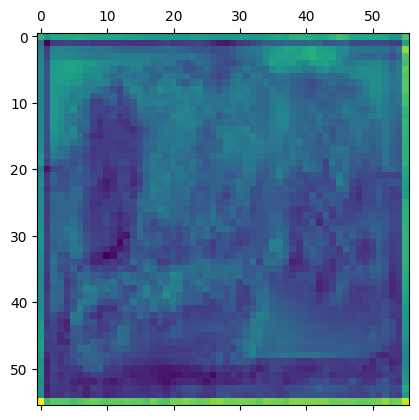

In [251]:
for i in range(32):
    activations[:, i, :, :] *= pooled_gradients[i]

heatmap = torch.mean(activations, dim=1).squeeze()

heatmap = np.maximum(heatmap, 0)
heatmap /= torch.max(heatmap)
plt.matshow(heatmap.squeeze())
plt.show()

In [254]:
import cv2
image = cv2.imread(img_path)

heatmap = cv2.resize(heatmap.numpy(), (image.shape[1], image.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.8 + image
cv2.imwrite('./map.jpg', superimposed_img)

True

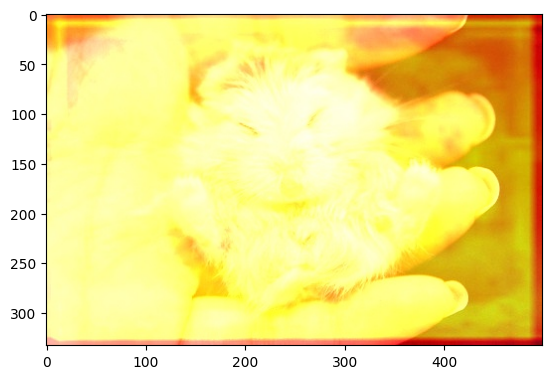

In [255]:
immap = plt.imread('./map.jpg')
plt.imshow(immap)